## Extraindo uma playlist de um usuário

In [1]:
%matplotlib notebook
#%matplotlib inline

import os
import json
import pandas as pd
import numpy as np
import io
import requests
import subprocess 
from numpy import array
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors


from random import shuffle
from matplotlib import style
style.use("ggplot")
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import *



In [2]:
# generate authorization token
def generate_token():
    with open('auth.json') as json_file:  
            data = json.load(json_file)

    auth_64 = data["auth_id"]
    
    
    cmd = ('curl -X "POST" -H "Authorization: Basic {0}" -d grant_type=client_credentials https://accounts.spotify.com/api/token').format(auth_64)

    output = subprocess.check_output(cmd,shell=True)
    tmp = json.loads(output)
    
    return(tmp["access_token"])

# get the playlist id from playlist link
def playlist_extrator(link):
    link = str(link)
    link = link.split('/')
    username = ''
    playlist_id = ''
    for i in range(0,len(link)):
        if link[i] == 'user':
            username = link[i+1]
        elif link[i] == 'playlist':
            playlist_id = link[i+1]
        
    return (username,playlist_id)
# request the playlist info
def generate_request(auth,playlist_link):
    username,playlist_id = playlist_extrator(playlist_link)
    link = ('curl -X GET "https://api.spotify.com/v1/users/{0}/playlists/{1}/tracks?market=BR" -H "Accept: application/json" -H "Authorization: Bearer {2}"'.format(username,playlist_id,auth))
    return link




In [3]:
# lists the musics from a playlist
def list_music(auth,playlist_link):
    
    link  = generate_request(auth,playlist_link)
    output = subprocess.check_output(link,shell=True)
    obj = json.loads(output)
    music = ''
    try:
        for values in obj['tracks']['items']:
            if values['track']['id'] != None:
                music += values['track']['id'] +','
    except:

        for items in obj['items']:
            if items['track']['id'] != None:
                music += items['track']['id'] +','
                
    return music

# get dictionary of music from list of ids

def get_music_from_id(auth,music_list): 
    all_music_id = ('curl -X GET "https://api.spotify.com/v1/audio-features/?ids={0}" -H "Authorization: Bearer {1}"'.format(music,auth))   
    output = subprocess.check_output(all_music_id,shell=True)
    music_feat = json.loads(output)
    return music_feat

In [4]:
# get means from music from playlist 
def music_feat_fit(length,music_feat):

    feat = music_feat["audio_features"]
    feat_mean = dict()
    
    danceability = []
    energy = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    valence = []
    loudness = []
    tempo = []
    liveness = []
    
    if music_feat == False:
        
        feat_mean['danceability']       = "None"
        feat_mean['energy']             = "None"
        feat_mean['speechiness']        = "None"
        feat_mean['acousticness']       = "None"
        feat_mean['instrumentalness']   = "None"
        feat_mean['valence']            = "None"
        feat_mean['loudness']           = "None"
        feat_mean['tempo']              = "None"
        feat_mean['liveness']           = "None"

        return feat_mean 
    
    for music in feat:
        try:
            danceability.append(music['danceability'])
            energy.append(music['energy'])
            speechiness.append(music['speechiness'])
            acousticness.append(music['acousticness'])
            instrumentalness.append(music['instrumentalness'])
            valence.append(music['valence'])
            loudness.append(music['loudness'])
            tempo.append(music['tempo'])
            liveness.append(music['liveness'])
        except:
            pass
        
    danceability = pd.Series(danceability)
    energy = pd.Series(energy)
    speechiness = pd.Series(speechiness)
    acousticness = pd.Series(acousticness)
    instrumentalness = pd.Series(instrumentalness)
    valence = pd.Series(valence)
    loudness = pd.Series(loudness)
    tempo = pd.Series(tempo)
    liveness = pd.Series(liveness)
       
    feat_mean['danceability']       = np.mean(danceability)
    feat_mean['energy']             = np.mean(energy)
    feat_mean['speechiness']        = np.mean(speechiness) 
    feat_mean['acousticness']       = np.mean(acousticness)
    feat_mean['instrumentalness']   = np.mean(instrumentalness)
    feat_mean['valence']            = np.mean(valence)
    feat_mean['loudness']           = np.mean(loudness)
    feat_mean['tempo']              = np.mean(tempo)
    feat_mean['liveness']           = np.mean(liveness)
    
    return feat_mean 

In [5]:
# Link da tabela das resposta do form
with open('auth.json') as json_file:  
            data = json.load(json_file)

# Criar um dataframe pelo CSV da tabela      
url = data['url']
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))


## Analisando os atributos de cada playlist

In [6]:
auth = generate_token()

for i, trial in df.iterrows():
#     print(len(trial))
    
#     print(trial[5])
    if len(trial)<=4 or str(trial[5])=="nan": 
        playlist_link = (trial[3])
        music = list_music(auth,playlist_link)
        music_feat = get_music_from_id(auth, music)
        ind_mean = music_feat_fit(len(music_feat["audio_features"]),music_feat) 

        df.loc[i, "danceability"]      = str(ind_mean["danceability"])         
        df.loc[i, "energy"]            = str(ind_mean["energy"])   
        df.loc[i, "speechiness"]       = str(ind_mean["speechiness"])        
        df.loc[i, "acousticness"]      = str(ind_mean["acousticness"])         
        df.loc[i, "instrumentalness"]  = str(ind_mean["instrumentalness"])             
        df.loc[i, "valence"]           = str(ind_mean["valence"])
        df.loc[i, "loudness"]          = str(ind_mean["loudness"])
        df.loc[i, "tempo"]             = str(ind_mean["tempo"])
        df.loc[i, "liveness"]          = str(ind_mean["liveness"])
    
    print(((i+1)/len(df)*100),"%")
        
clear_output()

In [7]:
# Deletando informações pessoais (e-mail e link da playlist do spotify)
try:
    df_names = df['Nome Completo']
    del df['Nome Completo']
    del df['Timestamp']
    del df['Email Address']
    del df['Link da sua playlist favorita do Spotify']
    del df['group']
    
except:
    pass

# print(df.keys())

In [8]:

# Salvando base de dados para o excel
writer = pd.ExcelWriter('Respostas.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

# Colocar os indices entre 1 e 0
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

df.columns=['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'loudness', 'tempo', 'liveness']

C:\Users\wesle\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [9]:
# df

##### Feature extraction|Test cluestering(teste/treinamento)

4    Manoela Cirne Lima De Campos
Name: Nome Completo, dtype: object


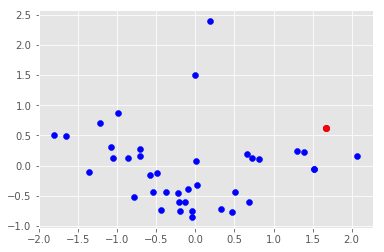

In [10]:
%matplotlib inline

X = np.array(df)
pca = PCA(n_components=2)
pca.fit(X)

num_pessoa = 4
num_pessoa_1 = num_pessoa+1
if num_pessoa >= len(df_names):
    num_pessoa_1 = num_pessoa
print(df_names[num_pessoa:num_pessoa_1])

reduct = pca.transform(X)
plt.scatter(reduct[:,0],reduct[:,1],c = 'b')

plt.plot(reduct[num_pessoa,0],reduct[num_pessoa,1],'ro')
plt.show()

In [11]:
# df_names

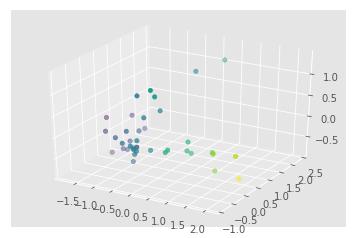

In [12]:
# %matplotlib notebook

A = np.array(df)
pca = PCA(n_components=3)
pca.fit(A)

# print(pca.get_precision(A))

Areduct = pca.transform(A)

x = Areduct[:,0] 
y = Areduct[:,1]
z = Areduct[:,2]
# c = Areduct[:,3]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=x)
plt.show()

In [13]:
# print(labels)
# print(len(labels))

Cluster 0 contains 10 samples
Cluster 1 contains 5 samples
Cluster 2 contains 12 samples
Cluster 3 contains 2 samples
Cluster 4 contains 7 samples
Cluster 5 contains 5 samples


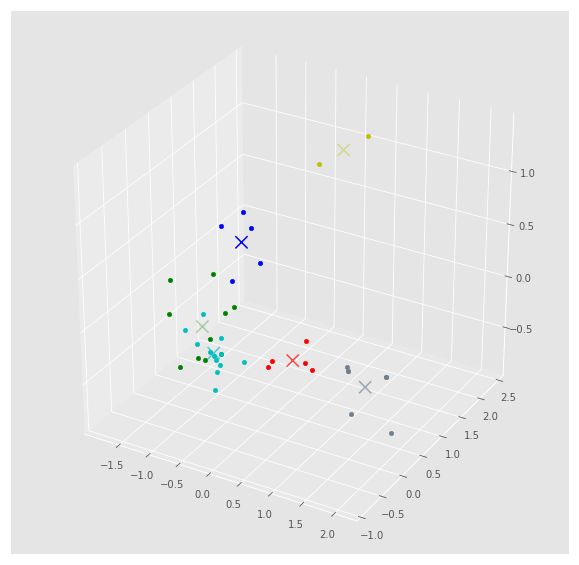

In [14]:


X = Areduct
cluster_num = int((len(Areduct))**(1/2))

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(Areduct)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = ['g','r','c','y','slategray', 'b', 'm']
# shuffle(colors)
colors = colors[:cluster_num]

c = Counter(labels)
# print(c)

fig = figure(figsize=(10,10))
# fig = figure()
ax = fig.gca(projection='3d')


for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]]) #color[labels[i]]
    pass
for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2], marker = "x", s=150, linewidths = 5, zorder = 100, c=colors)
plt.show()

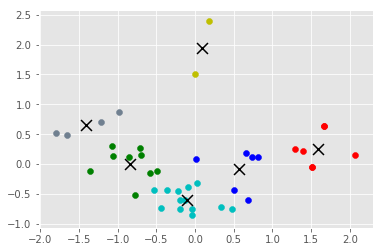

In [15]:
X = reduct
cluster_num = int((len(reduct))**(1/2))

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(reduct)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = ['g','r','c','y','slategray', 'b', 'm']
# shuffle(colors)
colors = colors[:cluster_num]

c = Counter(labels)


fig = figure()
ax = fig.gca()


for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], c=colors[labels[i]]) #color[labels[i]]
    pass
# num = 13
# ax.scatter(X[num][0],X[num][1],c='k')

for cluster_number in range(cluster_num):
#     print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
    pass
ax.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=120, linewidths = 20, zorder = 10,c="k" )#c=colors


In [16]:
# def order_colors(clusters_count, colors):
#     print(str(c).replace('}','{').split('{')[1:2].s)
#     pass

# for values in c:
#     print(values)

In [17]:
df['labels']  = labels
Xx = []
Xy = []
for i in X:
    Xx.append(i[0])
    Xy.append(i[1])
Xx = np.array(Xx)
Xy = np.array(Xy)
df["PCAx"] = Xx
df["PCAy"] = Xy

#df = df.sort_values(by=['labels'])
def calc_dist(A,B):
    dist = math.sqrt((A[1]-B[1])**2+(A[0]-B[0])**2)
    return dist
 
df = df.sort_index()


In [18]:

for i in list(c.keys()):
    DFgrupo = df.loc[df["labels"] == i]
    X = DFgrupo.as_matrix(["PCAx","PCAy"])
    index = list(df[df["labels"] == i].index)
    if(len(X) >= 3):
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(X)
        viz1 = []
        viz2 = []
        for k in indices:
            viz1.append(str(k[1]))
            viz2.append(str(k[2]))
            #Implementar global index
        df.loc[df["labels"] == i,'vizinho1'] = viz1
        df.loc[df["labels"] == i,'vizinho2'] = viz2
    else:
        df.loc[df["labels"] == i,'vizinho1'] = -1
        df.loc[df["labels"] == i,'vizinho2'] = -1
df

,danceability,energy,speechiness,acousticness,instrumentalness,valence,loudness,tempo,liveness,labels,PCAx,PCAy,vizinho1,vizinho2
0,0.535024,0.358529,-0.806609,-0.712598,-0.874280,-0.212776,0.582551,-0.228926,-0.544845,2,-0.536388,-0.437240,2,7
1,-0.486766,0.298642,-0.829993,-0.767879,-0.931314,-0.357780,0.524094,-0.079274,-0.468008,0,-0.855093,0.120283,4,8
2,0.639865,0.152169,0.862774,-0.312511,-0.995879,0.529307,0.505932,-0.981964,-0.579120,2,0.329539,-0.711256,4,6
3,-0.698383,0.498861,-0.094896,0.796026,-1.000000,1.000000,0.500776,1.000000,1.000000,3,0.184684,2.394054,-1,-1
4,-0.090265,-0.794344,-0.718254,0.986357,-0.980932,0.420675,-0.841096,-0.392945,-0.199819,1,1.666532,0.630545,2,1
5,-0.552988,0.219944,-0.968619,-0.689596,-0.894722,-0.304310,0.292264,-0.412060,-0.812383,0,-0.578962,-0.149579,3,4
6,0.058451,0.136072,-0.845485,-0.471854,-0.970647,-0.299546,0.522642,-0.363890,-0.871715,2,-0.369579,-0.432192,8,0
7,0.273756,-0.090974,-0.586817,-0.462050,-0.989187,-0.103987,0.557744,-0.401141,-0.947113,2,-0.135847,-0.599141,12,8
8,1.000000,-0.348962,0.220191,0.080481,-0.993346,0.431165,1.000000,-0.299874,-1.000000,2,0.472859,-0.760437,1,6
9,0.253953,0.205281,0.009074,-0.333815,-0.998129,0.015068,0.463388,-0.563607,-0.600858,2,-0.088745,-0.392330,11,8


In [28]:
print(df)
# print(df.loc[df['labels']==3])

# df.loc[df['labels']==3,"labels"] = [8,8]
# print(df.loc[df['labels']==8])

# df.loc[df['labels']==8,"labels"] = [3,3]
# print(df.loc[df['labels']==3])

    danceability    energy  speechiness  acousticness  instrumentalness  \
0       0.535024  0.358529    -0.806609     -0.712598         -0.874280   
1      -0.486766  0.298642    -0.829993     -0.767879         -0.931314   
2       0.639865  0.152169     0.862774     -0.312511         -0.995879   
3      -0.698383  0.498861    -0.094896      0.796026         -1.000000   
4      -0.090265 -0.794344    -0.718254      0.986357         -0.980932   
5      -0.552988  0.219944    -0.968619     -0.689596         -0.894722   
6       0.058451  0.136072    -0.845485     -0.471854         -0.970647   
7       0.273756 -0.090974    -0.586817     -0.462050         -0.989187   
8       1.000000 -0.348962     0.220191      0.080481         -0.993346   
9       0.253953  0.205281     0.009074     -0.333815         -0.998129   
10      0.099426  0.484709    -0.583688      0.429493         -0.999784   
11     -0.717447  0.820867    -0.691067     -0.930821         -0.979005   
12      0.195246 -0.06577

In [20]:
# distanciax = []
# distanciay = []
# for index,row in df.iterrows():
#     n_centro = row['labels']
#     centrox = centroids[int(n_centro),0]
#     centroy = centroids[int(n_centro),1]
#     distanciax.append(X[index][0] - centrox)
#     distanciay.append(X[index][1] - centroy)
# df['Dx'] = distanciax
# df['Dy'] = distanciay
# df = df.sort_values(by=['labels','Dx','Dy'], ascending = False)
# df

In [21]:
#df.loc[df["labels"] == 1,'teste'] = 1

In [22]:
df['nomes'] = df_names


In [23]:
#https://www.youtube.com/watch?v=vISRn5qFrkM (tutorial)
import gspread
from oauth2client.service_account import ServiceAccountCredentials

teste = json.loads(df.to_json())

values = []

for coluna in teste.keys():
    buffer = []
    buffer.append(coluna)
    for valor in teste[coluna].keys():
        buffer.append(teste[coluna][valor])
    values.append(buffer)
    
scope = ['https://spreadsheets.google.com/feeds']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json',scope)
client = gspread.authorize(creds)

# sheet = client.open('Spotifinder (Responses)').sheet1

#cell_list = sheet.range("A1:C7")
#g = sheet.cell(row, col)
#g = sheet.row_values(linha)
#g[2]

# titulos = df.keys()
# coluna = 1
# for i in titulos:
#     sheet.update_cell(1,coluna,i)
#     coluna += 1

In [24]:
df

,danceability,energy,speechiness,acousticness,instrumentalness,valence,loudness,tempo,liveness,labels,PCAx,PCAy,vizinho1,vizinho2,nomes
0,0.535024,0.358529,-0.806609,-0.712598,-0.874280,-0.212776,0.582551,-0.228926,-0.544845,2,-0.536388,-0.437240,2,7,David Fogelman
1,-0.486766,0.298642,-0.829993,-0.767879,-0.931314,-0.357780,0.524094,-0.079274,-0.468008,0,-0.855093,0.120283,4,8,Wesley Gabriel Albano Da Silva
2,0.639865,0.152169,0.862774,-0.312511,-0.995879,0.529307,0.505932,-0.981964,-0.579120,2,0.329539,-0.711256,4,6,André Neustein
3,-0.698383,0.498861,-0.094896,0.796026,-1.000000,1.000000,0.500776,1.000000,1.000000,3,0.184684,2.394054,-1,-1,Luca Salimon Nascimento
4,-0.090265,-0.794344,-0.718254,0.986357,-0.980932,0.420675,-0.841096,-0.392945,-0.199819,1,1.666532,0.630545,2,1,Manoela Cirne Lima De Campos
5,-0.552988,0.219944,-0.968619,-0.689596,-0.894722,-0.304310,0.292264,-0.412060,-0.812383,0,-0.578962,-0.149579,3,4,Pedro Villas Boas Dias
6,0.058451,0.136072,-0.845485,-0.471854,-0.970647,-0.299546,0.522642,-0.363890,-0.871715,2,-0.369579,-0.432192,8,0,Rodrigo Coutinho
7,0.273756,-0.090974,-0.586817,-0.462050,-0.989187,-0.103987,0.557744,-0.401141,-0.947113,2,-0.135847,-0.599141,12,8,Emanuelle Moço
8,1.000000,-0.348962,0.220191,0.080481,-0.993346,0.431165,1.000000,-0.299874,-1.000000,2,0.472859,-0.760437,1,6,Giovana Lemes
9,0.253953,0.205281,0.009074,-0.333815,-0.998129,0.015068,0.463388,-0.563607,-0.600858,2,-0.088745,-0.392330,11,8,Gabriel Pizzighini Salvador


In [25]:
respostas = pd.DataFrame()

In [26]:
df.loc[3,'vizinho1']

-1

In [27]:
respostas["nome"] = df["nomes"]